In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

#Minhas Bibliotecas
import DatasetAnalise as faa
import CreateVariables as facv
import SolveNullsAndPreparationData as fanp
import ModelsAdvancedAnalysis as fam

#pip install tpot
from sklearn.base import clone
import tpot as tpt

import random
import sys

2020-07-06 23:38:28,542 [INFO]  NumExpr defaulting to 4 threads.


# Carrega as bases necessárias

In [2]:
versao = '_v1'
pre_tratamento = '_processado'
nome_alvo = 'Survived'

#Dados de entradas de treino
df = pd.read_csv('bases/train' + pre_tratamento + versao + '.csv')

#Coloca a coluna de resposta no final
df = faa.colocaAlvoComeco(df, nome_alvo)

#Dados de entrada de teste
df_test = pd.read_csv('bases/test' + pre_tratamento + versao + '.csv')

#Dados das soluções dos dados de teste (modelo de submissão)
df_gender = pd.read_csv('submissoes/gender_submission.csv')

#Faz as coisas serem realmente aleatórias
seedValue = random.randrange(sys.maxsize)
random.seed(seedValue)

In [3]:
#Configura parâmetros estatísticos
num_loop = 5

#Configura se quer treinar novos modelos
fit_models = False

#Configura local para salvar ou carregar modelos
pasta_models = 1
save_models = False
load_models = True

#Configura se iremos usar algum tipo de balanceamento nas divisões entre treino e validação
balanced = 2

#  Cria base auxiliar para o modelo com nulos

In [4]:
df_aux = fanp.removeVarsCabins(df).copy()
df_test_aux = fanp.removeVarsCabins(df_test).copy()

# Tpots

In [5]:
#Configura parâmetros de busca de modelo
num_tpots1 = 4 #Quantas partes vamos quebrar o dataset
num_repetition1 = 1 #Quantas vezes vamos percorrer o dataset quebrando no número de partes definido

In [6]:
#Executa a "fábrica de modelos"
if(fit_models):
    num_tpots = num_tpots1
    num_repetition = num_repetition1
    df_modelos1, df_res1 = fam.iniciaListaModelos()
    for j in range(0, num_repetition):
        #Divide o dataset em várias partes, e vamos rodar o Tpot para cada uma delas
        dfs_search = fam.randomizaPartes(df_aux, nome_alvo, num_tpots, balanced)
        for i in range(0, num_tpots):
            df_search_temp = dfs_search[i]
            print('------------------------')
            print(str(1 + i + j*num_tpots) + '/' + str(num_tpots*num_repetition) + 
                  ' Tamanho do Espaço Amostral: ' + str(len(df_search_temp)))
            tpot = tpt.TPOTClassifier(generations = random.randint(2, 5), 
                                      population_size = random.randint(20, 50), 
                                      cv = random.randint(2, 5),
                                      subsample = 1,
                                      n_jobs = -1, 
                                      verbosity = 1)
            tpot.fit(df_search_temp.drop(nome_alvo, axis = 1), df_search_temp[nome_alvo])
            #Pega o melhor modelo encontrado pelo Tpot
            clf = tpot.fitted_pipeline_.steps[-1][1]
            clf.fit(df_aux.drop(nome_alvo, axis = 1), df_aux[nome_alvo])
            #Avalia esse modelo no dataset de trieno completo
            clt_temp = clone(clf)       
            df_metr, _ = fam.avaliaModelos([clt_temp], df_aux, nome_alvo, balanced, num_loop)
            #Salva o modelo e suas métricas nas tabelas
            numero_modelo = i + j*num_tpots
            fam.insereModelo(df_modelos1, numero_modelo, clf, df_res = df_res1, df_metr = df_metr)

In [7]:
#Salva os modelos treinados com suas métricas
if(save_models):
    fam.salvaModelos(1, df_modelos1, df_res1, pasta_models)
#Carrega os modelos e suas métricas
if(load_models):
    df_modelos1, df_res1 = fam.carregaModelos(1, pasta_models)

'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 79.8 ± 2.5
Acurácia Validação: 78.9 ± 1.0
Queda de Acurácia: 0.8 ± 2.5


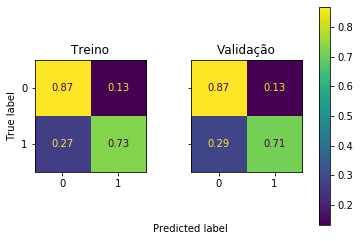

----------------------
ROC Treino: 89.4 ± 1.0
ROC Validação: 86.0 ± 1.1
Queda de ROC: 3.4 ± 2.0


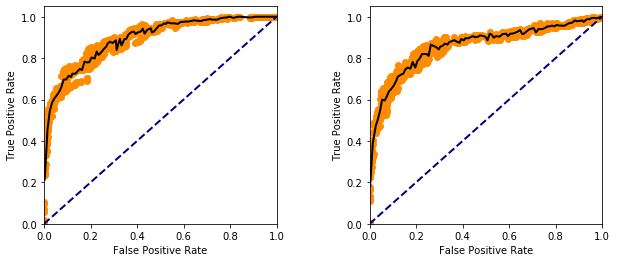

----------------------
KS Treino: 62.2 ± 2.5
KS Validação: 61.8 ± 2.3
Queda de KS: 0.3 ± 4.6


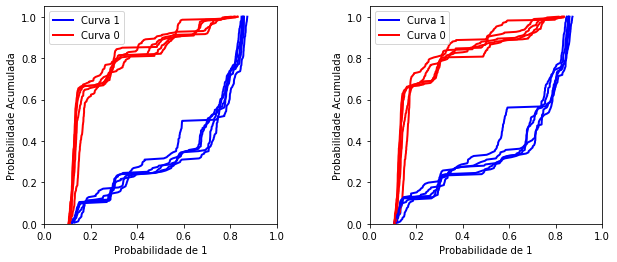

----------------------
Melhor Prob Corte Treino: 49.7 ± 9.7
Melhor Prob Corte Validação: 43.0 ± 10.4
Queda de Melhor Prob Corte: 6.7 ± 17.3
----------------------
Melhor Acurácia Treino: 81.1 ± 1.3
Melhor Acurácia Validação: 80.9 ± 1.1
Queda de Melhor Acurácia: 0.2 ± 2.3
 
****Avaliação por Quantidade de Treino****


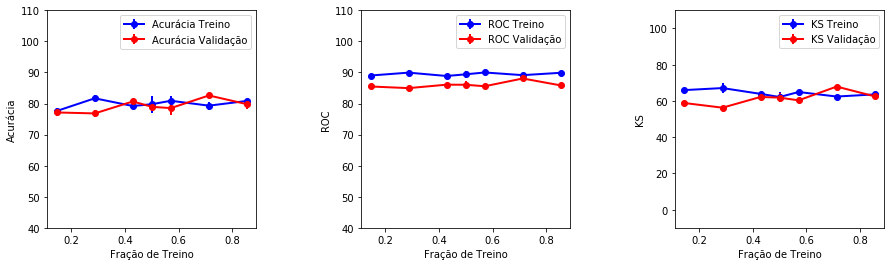

---------Evolução Ajustando Probabilidade de Corte---------


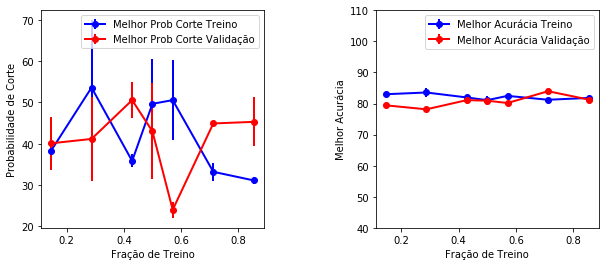

---------Valores Esperados---------
Acurácia: 81.2 ± 3.7
ROC: 86.8 ± 1.8
KS: 62.5 ± 5.4
Melhor Prob Corte: 32.3 ± 22.7
Melhor Acurácia: 81.3 ± 2.7
Fator de Qualidade: 0.01 ± 0.08


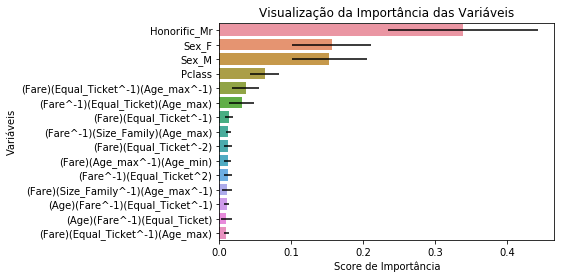

In [8]:
#Avalia o modelo médio dos melhores modelos encontrados
best_models1 = fam.getMelhoresModelos(df_modelos1, df_res1)
models1 = list(best_models1['modelo'])
_, _ = fam.avaliaModelos(models1, df_aux, nome_alvo, balanced, num_loop, flag_print = True)

# Cria arquivo de submissão

In [9]:
df_final = df_gender.copy()

models1 = list(best_models1['modelo'])
df_final['Survived'] = fam.predicaoModelos(models1, df_test_aux, prob_corte = 0.348)

df_final.to_csv('submissoes/gender_submission_modelo_medio' + versao + '.csv', index = False)
#df_final

# Cria base auxiliar para o ensemble modificado

In [10]:
models1 = list(best_models1['modelo'])

#Cria um dataset com a prob do modelo anterior como variavel de entrada
df2 = df.copy()
df2['prob_model'] = fam.predicaoProbModelos(models1, df_aux.drop(nome_alvo, axis = 1))
df_test2 = df_test.copy()
df_test2['prob_model'] = fam.predicaoProbModelos(models1, df_test_aux)

#Encontra os indices onde estão os valores não-nulos
ind_nn = df[df.isnull().sum(axis = 1) == 0].index
ind_test_nn = df_test[df_test.isnull().sum(axis = 1) == 0].index
#Encontra os indices onde estão os valores nulos
ind_n = df.drop(ind_nn).index
ind_test_n = df_test.drop(ind_test_nn).index

#Cria os dataset auxiliares
df_aux_nn = df2.loc[ind_nn, :].copy()
df_aux_n = df_aux.loc[ind_n, :].copy()
df_test_aux_nn = df_test2.loc[ind_test_nn, :].copy()
df_test_aux_n = df_test_aux.loc[ind_test_n, :].copy()

# Ensemble - Tpots

In [11]:
#Configura parâmetros de busca de modelo
num_tpots2 = 2 #Quantas partes vamos quebrar o dataset
num_repetition2 = 4 #Quantas vezes vamos percorrer o dataset quebrando no número de partes definido

In [12]:
#Executa a "fábrica de modelos"
if(fit_models):
    num_tpots = num_tpots2
    num_repetition = num_repetition2
    df_modelos2, df_res2 = fam.iniciaListaModelos()
    for j in range(0, num_repetition):
        #Divide o dataset em várias partes, e vamos rodar o Tpot para cada uma delas
        dfs_search = fam.randomizaPartes(df_aux_nn, nome_alvo, num_tpots, balanced)
        for i in range(0, num_tpots):
            df_search_temp = dfs_search[i]
            print('------------------------')
            print(str(1 + i + j*num_tpots) + '/' + str(num_tpots*num_repetition) + 
                  ' Tamanho do Espaço Amostral: ' + str(len(df_search_temp)))
            tpot = tpt.TPOTClassifier(generations = random.randint(2, 5), 
                                      population_size = random.randint(20, 50), 
                                      cv = random.randint(2, 5),
                                      subsample = 1,
                                      n_jobs = -1, 
                                      verbosity = 1)
            tpot.fit(df_search_temp.drop(nome_alvo, axis = 1), df_search_temp[nome_alvo])
            #Pega o melhor modelo encontrado pelo Tpot
            clf = tpot.fitted_pipeline_.steps[-1][1]
            clf.fit(df_aux_nn.drop(nome_alvo, axis = 1), df_aux_nn[nome_alvo])
            #Avalia esse modelo no dataset de trieno completo
            clt_temp = clone(clf)       
            df_metr, _, _ = fam.avaliaModelosConjunto([clt_temp], models1, df_aux_nn, df_aux_n, nome_alvo, balanced, num_loop)
            #Salva o modelo e suas métricas nas tabelas
            numero_modelo = i + j*num_tpots
            fam.insereModelo(df_modelos2, numero_modelo, clf, df_res = df_res2, df_metr = df_metr)

In [13]:
#Salva os modelos treinados com suas métricas
if(save_models):
    fam.salvaModelos(2, df_modelos2, df_res2, pasta_models)
#Carrega os modelos e suas métricas
if(load_models):
    df_modelos2, df_res2 = fam.carregaModelos(2, pasta_models)

'Progress: [####################] 100.0% Time Left: 0.0 min'

****Avaliação Meio a Meio****
----------------------
Acurácia Treino: 84.7 ± 1.4
Acurácia Validação: 79.5 ± 1.9
Queda de Acurácia: 5.2 ± 2.3


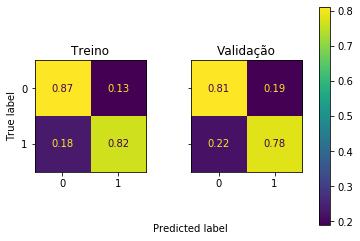

----------------------
ROC Treino: 91.3 ± 0.7
ROC Validação: 85.6 ± 0.3
Queda de ROC: 5.7 ± 1.0


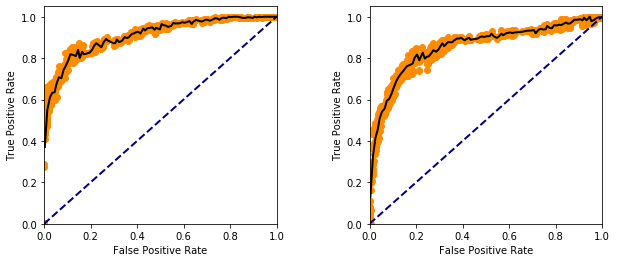

----------------------
KS Treino: 70.7 ± 2.0
KS Validação: 61.7 ± 2.0
Queda de KS: 9.1 ± 3.4


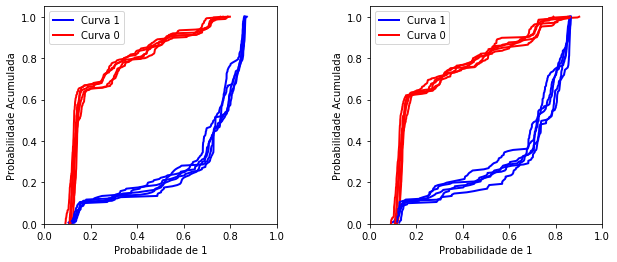

----------------------
Melhor Prob Corte Treino: 51.2 ± 5.4
Melhor Prob Corte Validação: 50.3 ± 3.0
Queda de Melhor Prob Corte: 0.9 ± 7.3
----------------------
Melhor Acurácia Treino: 85.4 ± 1.0
Melhor Acurácia Validação: 80.8 ± 1.0
Queda de Melhor Acurácia: 4.5 ± 1.7
 
****Avaliação por Quantidade de Treino****


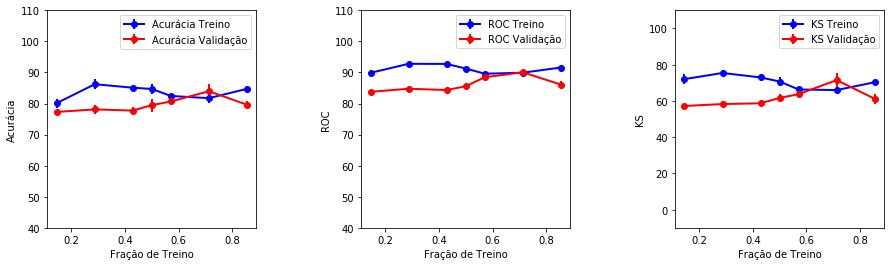

---------Evolução Ajustando Probabilidade de Corte---------


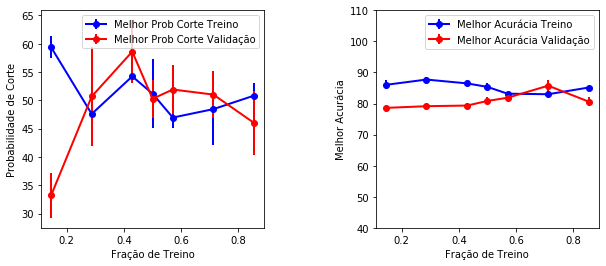

---------Valores Esperados---------
Acurácia: 81.0 ± 3.8
ROC: 87.3 ± 3.3
KS: 64.3 ± 7.9
Melhor Prob Corte: 47.4 ± 9.5
Melhor Acurácia: 82.2 ± 4.0
Fator de Qualidade: 0.11 ± 0.11


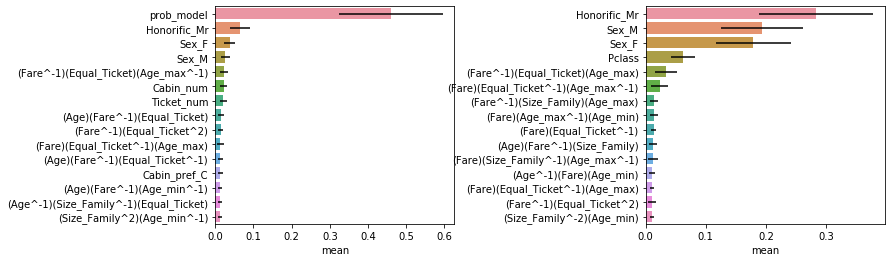

In [14]:
#Avalia o modelo médio dos melhores modelos
best_models2 = fam.getMelhoresModelos(df_modelos2, df_res2)
models2 = list(best_models2['modelo'])
_, _, _ = fam.avaliaModelosConjunto(models2, models1, df_aux_nn, df_aux_n, nome_alvo, balanced, num_loop, flag_print = True)

# Cria arquivo de submissão com predição conjunta

In [15]:
models2 = list(best_models2['modelo'])
df_final = df_gender.copy()
df_final['Survived'] = fam.predicaoModelosConjunto(models2, models1, df_test_aux_nn, df_test_aux_n)
df_final.to_csv('submissoes/gender_submission_modelo_medio-ensemble' + versao + '.csv', index = False)